## Python set-up

In [1]:
# system imports
from math import isfinite

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd
import readabs as ra
from IPython.display import display
import statsmodels.api as sm  # type: ignore

In [2]:
# local imports
from abs_helper import QUARTERLY_CPI_RANGE
from plotting import line_plot, finalise_plot, set_chart_dir, clear_chart_dir
from henderson import hma

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/Inflation-Model/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = False

## Data capture

 ### Identify the data we want to use

In [4]:
def get_data() -> tuple[dict[str, pd.Series], pd.DataFrame]:
    """Get a dictionary of data items from the ABS."""

    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"],
        "A3604510W": ["6401.0", "640106", "CPI_TM"],  # change from previous quarter
        "A2314867K": ["6427.0", "642701", "PPI"],  # change from previous year
        "A83895396W": ["6345.0", "634501", "WPI"],  # change from previous year
        "A84423050A": ["6202.0", "6202001", "UER"],  # percent of labour force
    }

    data, meta = {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        data[title] = d[series_id]
        meta[title] = m.loc[series_id]
    return data, pd.DataFrame(meta).T


_, META = get_data()
# check we have the correct variables
# META

### Collect and marshall that data
Assume we are only doind a one period prediction

In [5]:
def collect_data(subs: dict | None = None) -> tuple[pd.DataFrame, pd.Index, pd.Series]:
    """Collect the data for the inflation model.
    Arguments:
        subs: Dictionary of substitutions for forward values
    Returns:
        data: DataFrame containing the data
        exogenous: Index of exogenous variable names
        endogenous: Series of endogenous variables (ie CPI_TM)"""

    data_dict, meta = get_data()
    data_dict["UER"] = ra.monthly_to_qtly(data_dict["UER"])
    data = pd.concat(data_dict, axis=1)

    # forward for one period prediction
    last = data.loc[data.index[-1], "CPI_TM"]
    if isfinite(last):
        next = data.index[-1] + 1
        new_index = data.index.append(pd.PeriodIndex([next]))
        data = data.reindex(new_index)

    # populate forward exogenous guesses into the model
    last = data.index[-1]
    if subs is not None:
        for k, v in subs.items():
            if subs == "CPI_TM" or isfinite(data.loc[last, k]):
                continue
            data.loc[last, k] = v

    # Adjust missing values in PPI and WPI because they are published after CPI
    # so we may need rolling average approximations to plug in
    for s in ("PPI", "WPI"):
        "Do noting if next lines commented out ..."
        data[f"{s}_ADJ"] = data[s].where(
            data[s].notna(), other=data[s].rolling(4).mean().ffill()
        )
        # data = data.drop(columns=s)

    # smooth WPI/PPI
    h = 7
    for s in ("WPI", "PPI"):
        "Do noting if next lines commented ..."
        data[f"{s}_HMA[{h}]"] = hma(data[f"{s}_ADJ"].dropna(), h)

    # provide differences
    for col in ("PPI_ADJ", "WPI_ADJ", "UER"):
        data[f"Δ{col}"] = data[f"{s}_ADJ"].diff(1)

    # add autoregression
    for ar in (1, 2):
        data[f"CPI_TM-{ar}"] = data["CPI_TM"].shift(ar)

    # add the constant
    data["const"] = 1.0

    # Add a COVID dummy
    data["covid"] = 0
    mask = (data.index >= "2020Q1") & (data.index <= "2021Q1")
    data.loc[mask, "covid"] = 1

    # remove early nans
    remember = data.iloc[-1]
    data = pd.concat([data.dropna(), remember.to_frame().T])

    # exogenous and out-of-sample endogenous where known variables
    exogenous = data.columns.difference(["CPI_TM"])
    endogenous = data.index[-1]
    return data, exogenous, endogenous


DATA, EXOG, ENDOG = collect_data(subs={"UER": 4.1, "WPI": 4.0, "PPI": 4.3})
DATA.tail()

,CPI_TM,PPI,WPI,UER,PPI_ADJ,WPI_ADJ,WPI_HMA[7],PPI_HMA[7],ΔPPI_ADJ,ΔWPI_ADJ,ΔUER,CPI_TM-1,CPI_TM-2,const,covid
2023Q2,0.9,3.9,3.7,3.598759,3.9,3.7,3.770490,4.117343,-1.0,-1.0,-1.0,1.2,1.7,1.0,0.0
2023Q3,1.2,3.8,4.0,3.683085,3.8,4.0,3.994126,3.835245,-0.1,-0.1,-0.1,0.9,1.2,1.0,0.0
2023Q4,0.8,4.1,4.2,3.884424,4.1,4.2,4.117762,4.041259,0.3,0.3,0.3,1.2,0.9,1.0,0.0
2024Q1,1.0,4.3,4.1,3.893204,4.3,4.1,4.109752,4.358878,0.2,0.2,0.2,0.8,1.2,1.0,0.0
2024Q3,NaN,4.3,4.0,4.100000,4.3,4.0,3.975287,4.544849,-0.5,-0.5,-0.5,0.8,1.0,1.0,0.0


In [6]:
EXOG

Index(['CPI_TM-1', 'CPI_TM-2', 'PPI', 'PPI_ADJ', 'PPI_HMA[7]', 'UER', 'WPI',
       'WPI_ADJ', 'WPI_HMA[7]', 'const', 'covid', 'ΔPPI_ADJ', 'ΔUER',
       'ΔWPI_ADJ'],
      dtype='object')

In [7]:
ENDOG

Period('2024Q3', 'Q-DEC')

## Build a simple multiple regression model

In [8]:
forecasts = {}


def run_model(data, exog: list[str], title: str, endog: pd.Series | None):

    # Fit the model
    y = data["CPI_TM"].dropna()
    X = data.loc[y.index, exog]
    Xnew = data.loc[data.index.difference(X.index), exog]
    print(X.tail())
    model = sm.OLS(y, X)
    fit = model.fit()
    print(fit.summary())

    # QQ plot
    fig = sm.qqplot(fit.resid, line="s")
    name = title.split(" vs ")[1].rsplit(" ", 1)[0]
    finalise_plot(
        fig.axes[0],
        title=f"QQ Plot: {name}",
        xlabel="Theoretical Quantiles",
        ylabel="Sample Quantiles",
        show=SHOW,
    )

    # can we forecast?
    can_forecast = endog is not None and len(Xnew) > 0
    if can_forecast:
        print("Forecasting using:")
        display(Xnew)
        ynewpred = fit.predict(Xnew)  # predict out of sample
        display(ynewpred)
        forecasts[title] = ynewpred.iloc[0]
        ynewpred[y.index[-1]] = y.iloc[-1]  # start from actual
        quarterly = ynewpred.iloc[1]
        annual = (
            (((pd.concat([y.iloc[-3:-1], ynewpred]) / 100) + 1).cumprod() - 1) * 100
        ).iloc[-1]
        projection = (
            f"Projection {ynewpred.index[-1]}: A:{annual:.2f}% Q:{quarterly:.2f}%"
        )
    projection = projection if can_forecast else ""

    # plot avtual vs predicted
    mlist = [f"({x}*{round(y, 3)})" for x, y in fit.params.items()]
    m = "ypred = " + (" + ").join(mlist)
    print("Model: ", m)
    ypred = fit.predict(X)
    model_frame = pd.DataFrame({"Actual": y, "Within sample predicted": ypred})
    if can_forecast:
        model_frame = model_frame.reindex(model_frame.index.union(ynewpred.index))
        model_frame["Out of sample forecast"] = ynewpred
    line_plot(
        model_frame,
        title=title,
        ylabel="Inflation % per quarter",
        color=("cornflowerblue", "darkorange", "darkred"),
        width=(1.5, 2, 3),
        axhspan=QUARTERLY_CPI_RANGE,
        lfooter=m if len(m) < 80 else "",
        y0=True,
        show=SHOW,
    )

        CPI_TM-1  CPI_TM-2  PPI  PPI_ADJ  PPI_HMA[7]       UER  WPI  WPI_ADJ  \
2023Q1       1.7       1.8  4.9      4.9    4.900000  3.610038  3.6      3.6   
2023Q2       1.2       1.7  3.9      3.9    4.117343  3.598759  3.7      3.7   
2023Q3       0.9       1.2  3.8      3.8    3.835245  3.683085  4.0      4.0   
2023Q4       1.2       0.9  4.1      4.1    4.041259  3.884424  4.2      4.2   
2024Q1       0.8       1.2  4.3      4.3    4.358878  3.893204  4.1      4.1   

        WPI_HMA[7]  const  covid  ΔPPI_ADJ  ΔUER  ΔWPI_ADJ  
2023Q1    3.558881    1.0    0.0      -0.9  -0.9      -0.9  
2023Q2    3.770490    1.0    0.0      -1.0  -1.0      -1.0  
2023Q3    3.994126    1.0    0.0      -0.1  -0.1      -0.1  
2023Q4    4.117762    1.0    0.0       0.3   0.3       0.3  
2024Q1    4.109752    1.0    0.0       0.2   0.2       0.2  
                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0

,CPI_TM-1,CPI_TM-2,PPI,PPI_ADJ,PPI_HMA[7],UER,WPI,WPI_ADJ,WPI_HMA[7],const,covid,ΔPPI_ADJ,ΔUER,ΔWPI_ADJ
2024Q3,0.8,1.0,4.3,4.3,4.544849,4.1,4.0,4.0,3.975287,1.0,0.0,-0.5,-0.5,-0.5


2024Q3    0.933623
Freq: Q-DEC, dtype: float64

Model:  ypred = (CPI_TM-1*0.389) + (CPI_TM-2*0.232) + (PPI*-0.047) + (PPI_ADJ*-0.047) + (PPI_HMA[7]*0.13) + (UER*-0.048) + (WPI*0.008) + (WPI_ADJ*0.008) + (WPI_HMA[7]*-0.018) + (const*0.439) + (covid*0.0) + (ΔPPI_ADJ*0.016) + (ΔUER*0.016) + (ΔWPI_ADJ*0.016)


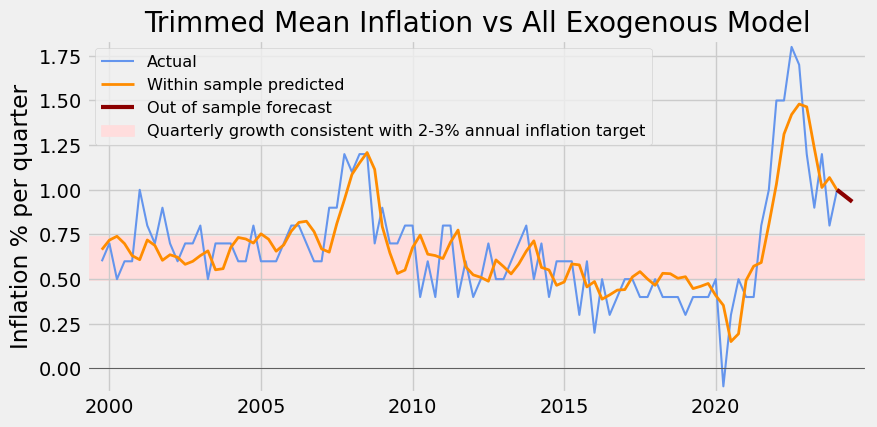

In [9]:
# Simple everything model
title = "Trimmed Mean Inflation vs All Exogenous Model"
run_model(DATA, EXOG.to_list(), title, ENDOG)

        CPI_TM-1  CPI_TM-2  PPI_HMA[7]  const  covid
2023Q1       1.7       1.8    4.900000    1.0    0.0
2023Q2       1.2       1.7    4.117343    1.0    0.0
2023Q3       0.9       1.2    3.835245    1.0    0.0
2023Q4       1.2       0.9    4.041259    1.0    0.0
2024Q1       0.8       1.2    4.358878    1.0    0.0
                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     39.82
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           2.14e-19
Time:                        12:27:24   Log-Likelihood:                 26.458
No. Observations:                  98   AIC:                            -42.92
Df Residuals:                      93   BIC:                            -29.99
Df Model:                           4             

,CPI_TM-1,CPI_TM-2,PPI_HMA[7],const,covid
2024Q3,0.8,1.0,4.544849,1.0,0.0


2024Q3    0.90746
Freq: Q-DEC, dtype: float64

Model:  ypred = (CPI_TM-1*0.424) + (CPI_TM-2*0.205) + (PPI_HMA[7]*0.051) + (const*0.13) + (covid*-0.016)


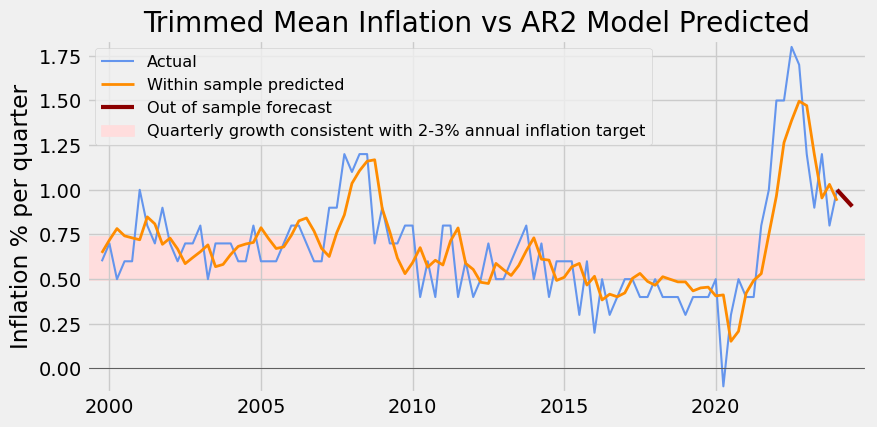

In [10]:
# REMOVE some cooefficients that are not significantly different from zero
exog_1 = EXOG.difference(
    [
        "WPI",
        "WPI_ADJ",
        "WPI_HMA[7]",
        "PPI",
        "PPI_ADJ",
        "UER",
        "ΔPPI_ADJ",
        "ΔUER",
        "ΔWPI_ADJ",
    ]
).to_list()
title = "Trimmed Mean Inflation vs AR2 Model Predicted"
run_model(DATA, exog_1, title, ENDOG)

        CPI_TM-1       UER  covid  const
2023Q1       1.7  3.610038    0.0    1.0
2023Q2       1.2  3.598759    0.0    1.0
2023Q3       0.9  3.683085    0.0    1.0
2023Q4       1.2  3.884424    0.0    1.0
2024Q1       0.8  3.893204    0.0    1.0
                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     47.95
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           6.86e-19
Time:                        12:27:24   Log-Likelihood:                 23.050
No. Observations:                  98   AIC:                            -38.10
Df Residuals:                      94   BIC:                            -27.76
Df Model:                           3                                         
Covariance Type:            nonrobust      

,CPI_TM-1,UER,covid,const
2024Q3,0.8,4.1,0.0,1.0


2024Q3    0.866552
Freq: Q-DEC, dtype: float64

Model:  ypred = (CPI_TM-1*0.605) + (UER*-0.087) + (covid*-0.058) + (const*0.741)


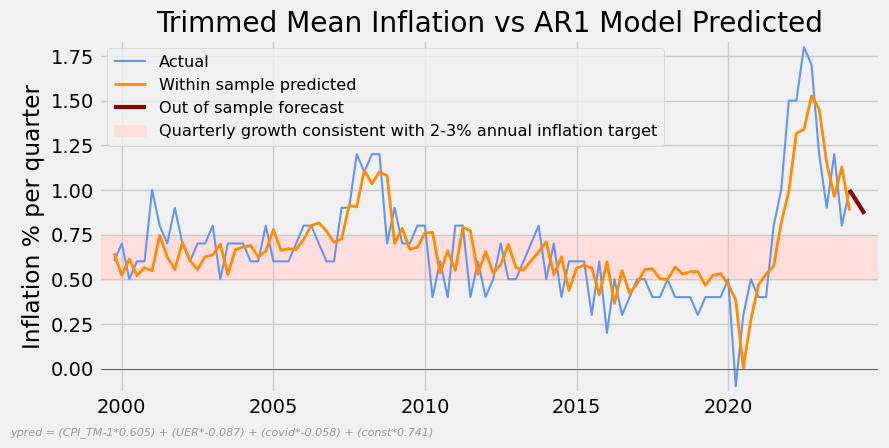

In [11]:
exog_ = ["CPI_TM-1", "UER", "covid", "const"]
title = "Trimmed Mean Inflation vs AR1 Model Predicted"
run_model(DATA, exog_, title, ENDOG)

        CPI_TM-1  CPI_TM-2  ΔUER  PPI_HMA[7]  WPI_HMA[7]  covid
2023Q1       1.7       1.8  -0.9    4.900000    3.558881    0.0
2023Q2       1.2       1.7  -1.0    4.117343    3.770490    0.0
2023Q3       0.9       1.2  -0.1    3.835245    3.994126    0.0
2023Q4       1.2       0.9   0.3    4.041259    4.117762    0.0
2024Q1       0.8       1.2   0.2    4.358878    4.109752    0.0
                                 OLS Regression Results                                
Dep. Variable:                 CPI_TM   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              232.3
Date:                Fri, 02 Aug 2024   Prob (F-statistic):                    2.64e-53
Time:                        12:27:25   Log-Likelihood:                          26.408
No. Observations:                  98   AIC:                                     -40.82


,CPI_TM-1,CPI_TM-2,ΔUER,PPI_HMA[7],WPI_HMA[7],covid
2024Q3,0.8,1.0,-0.5,4.544849,3.975287,0.0


2024Q3    0.897038
Freq: Q-DEC, dtype: float64

Model:  ypred = (CPI_TM-1*0.443) + (CPI_TM-2*0.247) + (ΔUER*0.041) + (PPI_HMA[7]*0.039) + (WPI_HMA[7]*0.034) + (covid*0.051)


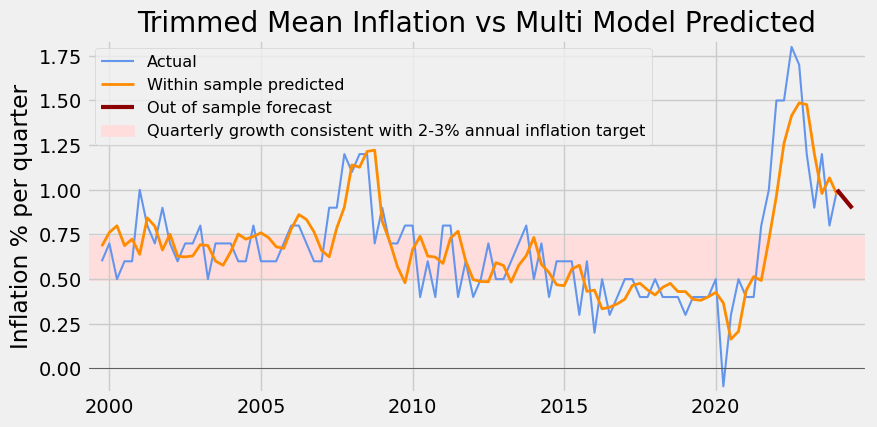

In [12]:
# Multi-model
# exog_ = ['CPI_TM-1', 'CPI_TM-2', "UER", "WPI_HMA[7]", "PPI_HMA[7]",  "const"]
# exog_ = ['CPI_TM-1', 'CPI_TM-2', "PPI_HMA[7]"]  # <-- the best model (no employment)
# exog_ = ['CPI_TM-1', 'CPI_TM-2', "WPI_HMA[7]"]
exog_ = ["CPI_TM-1", "CPI_TM-2", "ΔUER", "PPI_HMA[7]", "WPI_HMA[7]", "covid"]
title = "Trimmed Mean Inflation vs Multi Model Predicted"
run_model(DATA, exog_, title, ENDOG)

In [13]:
# mean of all models
pd.Series(forecasts).mean()

0.9011683074806378

## Backtest

In [14]:
BACK_DATA = DATA.iloc[:-1]
BACK_INDEX = BACK_DATA.index[-1]
ACTUAL = BACK_DATA.iloc[-1, 0]
BACK_DATA.iloc[-1, 0] = None
BACK_DATA.tail(), BACK_INDEX

(        CPI_TM  PPI  WPI       UER  PPI_ADJ  WPI_ADJ  WPI_HMA[7]  PPI_HMA[7]  \
 2023Q1     1.2  4.9  3.6  3.610038      4.9      3.6    3.558881    4.900000   
 2023Q2     0.9  3.9  3.7  3.598759      3.9      3.7    3.770490    4.117343   
 2023Q3     1.2  3.8  4.0  3.683085      3.8      4.0    3.994126    3.835245   
 2023Q4     0.8  4.1  4.2  3.884424      4.1      4.2    4.117762    4.041259   
 2024Q1     NaN  4.3  4.1  3.893204      4.3      4.1    4.109752    4.358878   
 
         ΔPPI_ADJ  ΔWPI_ADJ  ΔUER  CPI_TM-1  CPI_TM-2  const  covid  
 2023Q1      -0.9      -0.9  -0.9       1.7       1.8    1.0    0.0  
 2023Q2      -1.0      -1.0  -1.0       1.2       1.7    1.0    0.0  
 2023Q3      -0.1      -0.1  -0.1       0.9       1.2    1.0    0.0  
 2023Q4       0.3       0.3   0.3       1.2       0.9    1.0    0.0  
 2024Q1       0.2       0.2   0.2       0.8       1.2    1.0    0.0  ,
 Period('2024Q1', 'Q-DEC'))

        CPI_TM-1  CPI_TM-2  ΔUER  PPI_HMA[7]  WPI_HMA[7]  covid
2022Q4       1.8       1.5  -0.6    5.758881    3.358741    0.0
2023Q1       1.7       1.8  -0.9    4.900000    3.558881    0.0
2023Q2       1.2       1.7  -1.0    4.117343    3.770490    0.0
2023Q3       0.9       1.2  -0.1    3.835245    3.994126    0.0
2023Q4       1.2       0.9   0.3    4.041259    4.117762    0.0
                                 OLS Regression Results                                
Dep. Variable:                 CPI_TM   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              225.3
Date:                Fri, 02 Aug 2024   Prob (F-statistic):                    2.40e-52
Time:                        12:27:25   Log-Likelihood:                          25.653
No. Observations:                  97   AIC:                                     -39.31


,CPI_TM-1,CPI_TM-2,ΔUER,PPI_HMA[7],WPI_HMA[7],covid
2024Q1,0.8,1.2,0.2,4.358878,4.109752,0.0


2024Q1    0.970283
Freq: Q-DEC, dtype: float64

Model:  ypred = (CPI_TM-1*0.446) + (CPI_TM-2*0.244) + (ΔUER*0.041) + (PPI_HMA[7]*0.039) + (WPI_HMA[7]*0.034) + (covid*0.051)


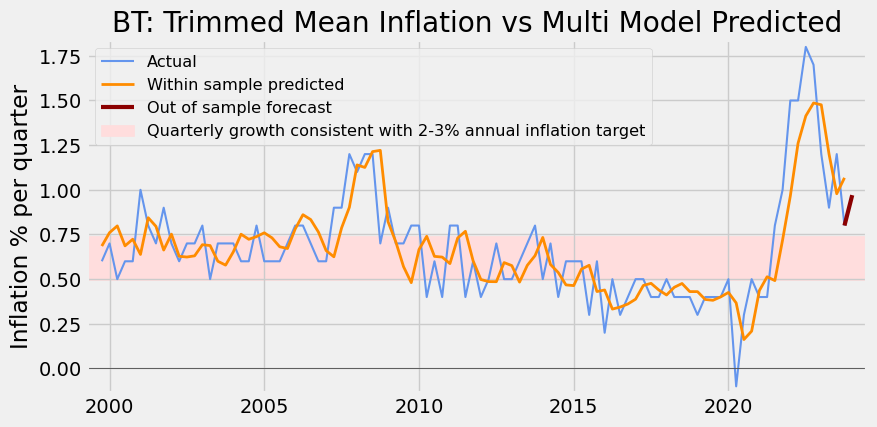

In [15]:
exog = ["CPI_TM-1", "CPI_TM-2", "ΔUER", "PPI_HMA[7]", "WPI_HMA[7]", "covid"]
title = "BT: Trimmed Mean Inflation vs Multi Model Predicted"
run_model(BACK_DATA, exog, title, ENDOG)

## Finished

In [16]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Aug 02 2024 12:27:26

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pandas     : 2.2.2
matplotlib : 3.9.1
readabs    : 0.0.17
statsmodels: 0.14.2

Watermark: 2.4.3



In [17]:
print("Finished")

Finished
